In [131]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import fetch_openml

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# To sort the dataset to duplicate dataset in example:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns
# targets as strings
sort_by_target(mnist)
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 images, each image has 784 features (each image is 28x28 px = 784). Each feature represents one pixel's intensity (from 0 (white) to 255 (black)).

Let's peek at one digit from the dataset. Grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's imshow() function.

In [7]:
28*28

784

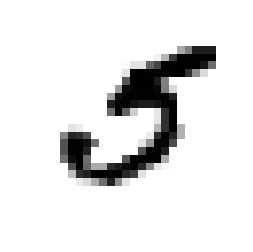

In [21]:
some_digit = X[36000] # we randomly chose 36000
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
          interpolation = 'nearest')
plt.axis('off')

plt.show()

In [23]:
y[36000]

5

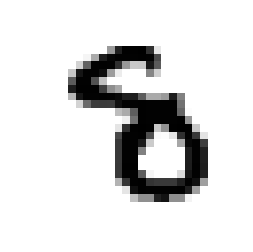

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
plot_digit(X[50000])

In [28]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

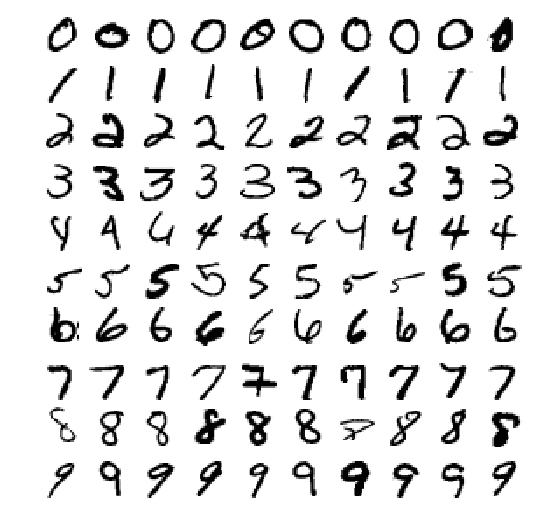

In [30]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's shuffle the dataset so all cross-validation folds will be similar.

In [32]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

First we'll only try to identify one digit--the number 5. This is a *binary classifier*.

In [33]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

We'll start with a *Stochastic Gradient Descent* (SGD) Classifier (sklearn's SGDClassifier class).

SGDClassifier handles very large datasets efficiently.

In [37]:
# Create SGDClassifier and train it on whole training set
sgd_clf = SGDClassifier(max_iter=5, tol=np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring Accuracy Using Cross-Validation

In [40]:
cross_val_score(sgd_clf, 
                X_train, 
                y_train_5, 
                cv=3, scoring='accuracy')

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.9502 , 0.96565, 0.96495])

We can implement CV ourselves in case we need more control over the CV by using sklearn's StratifiedKFold class:

In [43]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9502


/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.96565


/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.96495


These 95% accuracies may look great, but accuracy isn't the best measure for classifiers. Let's look at a dumb classifier that classifies every single image in the "not-5" class:

In [46]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [47]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, 
                X_train,
                y_train_5,
                cv=3,
                scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*. It counts the number of times instances of class A are classified as class B, for any number of possible instances.

First, we need a set of predictions to compare to the actual targets. To do this, use the cross_val_predict() function:

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [51]:
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

A perfect prediction would have non-zero numbers only in its main diagonal:

In [52]:
y_train_perfect_predictions = y_train_5

In [53]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

A more concise metric to the confusion matrix is Precision & Recall.

**Precision = TP / (TP + FP)**

-  Accuracy of the positive predictions
-  How many did we get right out of how many we guessed right?

**Recall = TP / (TP + FN)**

-  Sensitivity, or True Positive Rate (TPR)
-  The ratio of positive instances that are correctly detected by the classifier
-  How many did we get right out of how many were actually right?

Sklearn provides precision_score and recall_score functions:

In [55]:
precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [56]:
# Precision from the confusion matrix
4344 / (4344 + 1307)

0.7687135020350381

For precision = 77%, this means when it claims an image represents a 5, it is correct only 77% of the time.

In [57]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [59]:
# Recall from the confusion matrix
4344 / (4344 + 1077)

0.801328168234643

For recall = 80%, it only detects 80% of the 5s.

It's convenient to combine precision and recall into a single metric called the *F1 score*, the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. Therefore, the classifier will only get a high F1 score if both recall and precision are high.

F1 = 2 * (precision * recall) / (precision + recall)

-  The higher the beta value, the higher the importance is put on precision. This is necessary for things like predicting cancer. You DON'T want to get false positives, so you want to be very precise with how many you get right out of how many you guess (low FP). But with other applications, it may be important to have high recall, such as predicting whether 1 person in 10000 has a disease. You may not precisely know everyone who has it, but at least you predicted who actually had it within your predictions (Low FN). A beta of .5 gives equal weight to precision and recall--this is considered the F1 measure.

In [61]:
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [62]:
# F1 score from confusion matrix
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

We can adjust the threshold using sklearn's decision_function to add weight to precision or recall. Higher threshold means lower recall, vice versa.

In [63]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [65]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [66]:
y_some_digit_pred

array([ True])

In [68]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The image is actually a 5. The classifier detects it when threshold=0, but misses it when threshold is increased to 200,000.

How do we decide what threshold to use?

Get the scores of all instances in the training set using cross_val_predict() function again, but this time specify you want it to return decision scores instead of predictions:

In [69]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Now compute precision/recall for all possible thresholds using sklearn's precision_recall_curve() function:

In [71]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot precision and recalls as functions of the threshold value using Matplotlib:

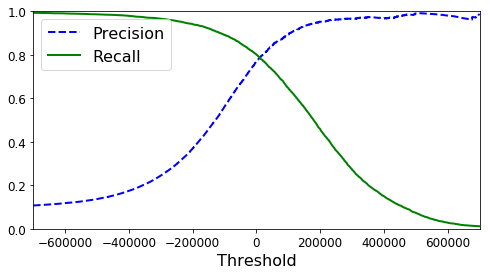

In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--',
             label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-',
             label='Recall', linewidth=2)
    plt.xlabel('Threshold', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [79]:
(y_train_pred == (y_scores > 0)).all()

True

Now select the threshold value that gives you the best precision/recall tradeoff for your task.

Let's say we decide to aim for 90% precision, so we need threshold of about 70,000. To make predictions, instead of calling the classifier's predict() method, we can just run this code:

In [75]:
y_train_pred_90 = (y_scores > 70000)

In [80]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [81]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

Or you can plot a precision vs. recall graph:

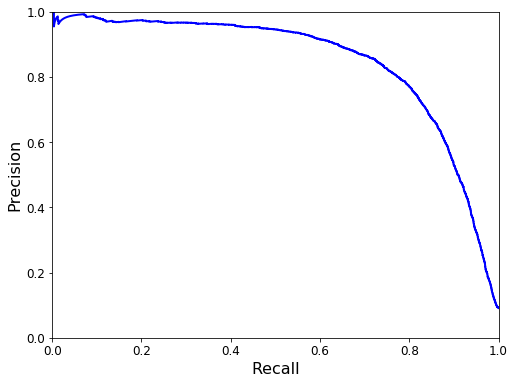

In [82]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

ROC curve is similar to precision/recall curve, but instead of plotting precision vs. recall, it plots true positive rate (Recall) against false positive rate (specificity). So it plots sensitivity (recall) versus 1 - specificity.

First compute the TPR and FPR for various threshold values using roc_curve() function:

In [84]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then plot FPR against TPR using Matplotlib.

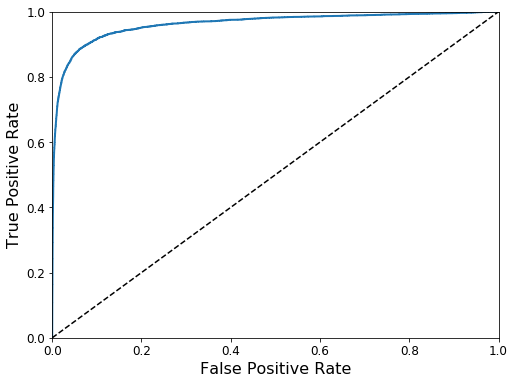

In [85]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Tradeoff: higher the recall (TPR), the more false positives (FPR) the classifier produces.

The dotted line is the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards top left corner).

One way to compare classifiers is to measure *area under the curve* (AUC). A perfect classifier will have ROC AUC equal to 1, purely random will equal 0.5.

Use sklearn's roc_auc_score function:

In [87]:
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

Use the PR curve when the positive class is rare, or you care more about false positives than false negatives.

Use the ROC curve (and ROC AUC score) otherwise.

Here, the ROC curve and ROC AUC score may look great, but this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

Let's train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

RandomForestClassifier doesn't have decision_function, it has predict_proba() method, returning an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (ie 70% chance that the image represents a 5):

In [90]:
forest_clf = RandomForestClassifier(n_estimators=10, 
                                    random_state=42)
y_probas_forest = cross_val_predict(forest_clf,
                                    X_train, y_train_5, cv=3,
                                    method='predict_proba')

But to plot a ROC curve, we need scores, not probabilities. So use the positive class's probability as the score:

In [92]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of
# positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,
                                                      y_scores_forest)

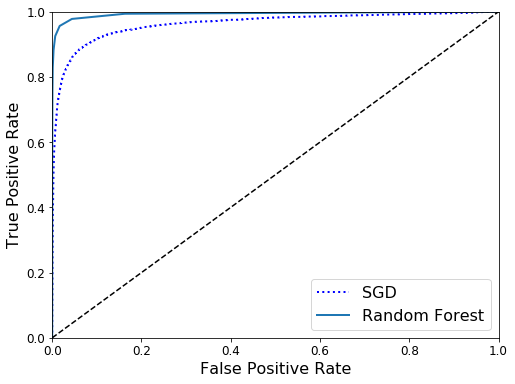

In [93]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=16)
plt.show()

RandomForestClassifier's ROC curve looks much better than SGDClassifier's (much closer to top left corner). Therefore its ROC AUC score is also significantly better:

In [94]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

Now try its precision and recall scores:

In [95]:
y_train_pred_forest = cross_val_predict(forest_clf,
                                        X_train,
                                        y_train_5,
                                        cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [96]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass Classification

Some algorithms, like Random Forest classifiers or naive Bayes classifiers can handle multiple classes directly.

Others, like SVM classifiers or Linear classifiers, are strictly binary classifiers. But there are strategies to perform multiclass classification using multiple binary classifiers.

Strategies for binary classifiers:

*One-versus-all* (OvA):
-  For example, a system to classify digit images into 10 classes (from 0-9): train 10 binary classifiers, one for each digit. Then get the decision score from each classifier for that image and select the class whose classifier outputs the highest score.

*One-versus-one* (OvO):
-  Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, etc.
-  If there are N classes, you need to train [ N x (N - 1) / 2 ] classifiers.
-  For MNIST, this means training 45 binary classifiers.
-  The main advantage of OvO is each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.
-  Some algorithms (like SVM) scale poorly with the size of the training set, so OvO is preferred since it's faster to train many classifiers on small training sets than training few classifiers on large training sets.
-  For most binary classification algorithms, however, OvA is preferred.

Sklearn detects when you try to use a binary classification algorithm for a multi-class classification task, and automatically runs OvA (except for SVM classifiers it uses OvO).

In [97]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([5], dtype=int8)

In [98]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

To see that sklearn trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score, we can call the decision_function() method. Instead of returning just one score per instance, it returns 10 scores, 1 per class:

In [99]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

The highest score corresponds to class 5:

In [100]:
np.argmax(some_digit_scores)

5

In [101]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [103]:
sgd_clf.classes_[5]

5

You can force sklearn to use OvA or OvO using OneVsOneClassifier or OneVsRestClassifier classes:

In [106]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

array([5], dtype=int8)

In [107]:
len(ovo_clf.estimators_)

45

Training a RandomForestClassifier is just as easy:

In [108]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

This time sklearn didn't have to run OvA or OvO because Random Forest classifiers can dierectly classify instances into multiple classes. We can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [109]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

The classifier is 80% sure it's a 5, 10% sure it's either a 0 or a 3.

Now we will evaluate these classifiers. We'll use cross-validation. Let's evaluate the SGDClassifier's accuracy using the cross_val_score() function:

In [110]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, 
                scoring='accuracy')

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.84063187, 0.84899245, 0.86652998])

We get over 84% on all test folds. A random classifier would get 10% accuracy, so this is not a bad score. But we can do much better. For example, simply scaling the inputs increases accuracy above 90%:

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
                scoring='accuracy')

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91011798, 0.90874544, 0.906636  ])

# Error Analysis

We'll assume we've found a promising model and want to find ways to improve it.

One way is to analyze the types of errors it makes.

First, look at the confusion matrix. Make predictions using the cross_val_predict() function, then call the confusion_matrix():

In [114]:
y_train_pred = cross_val_predict(sgd_clf,
                                 X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Gregs_Computer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

Use Matplotlib's matshow() function to visually represent the confusion matrix.

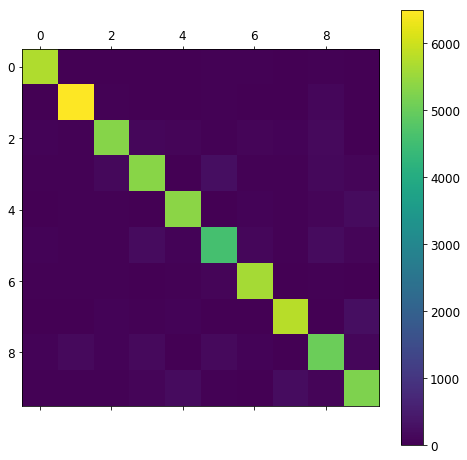

In [115]:
def plot_confusion_matrix(matrix):
    '''if you prefer color and a colorbar'''
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
plot_confusion_matrix(conf_mx)

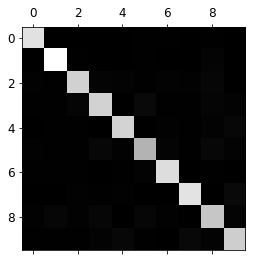

In [116]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s is slightly darker, meaning either there are fewer images of 5s in the dataset or the classifier does not perform as well on 5s as on other digits. We can verify that both are the case.

Let's focus on the plot errors. First, we'll divide each value in the confusion matrix by the number of images in the corresponding class so we can compare error rates, not just absolute number of errors.

In [123]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

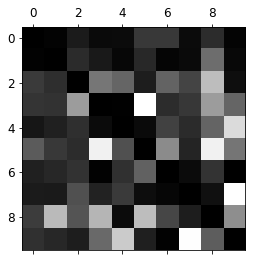

In [127]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Remember rows are actual, columns are predicted.

The columns for 8 and 9 are quite bright, telling us that 8s and 9s are often confused with other digits.

Some rows are pretty dark, such as row 1, meaning most 1s are classified correctly (but a few are confused with 8s).

Analyzing this plot, it seems our efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion.

We could try to gather more training data for these digits.
We could engineer new features that would help the classifier (ie writing an algorithm to count the number of closed loops, 8 has 2, 6 has 1, 5 has none). Or we could preprocess the images (using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

We can analyze individual errors to gain insights, but it is more difficult and time-consuming. Let's plot examples of 3s and 5s:

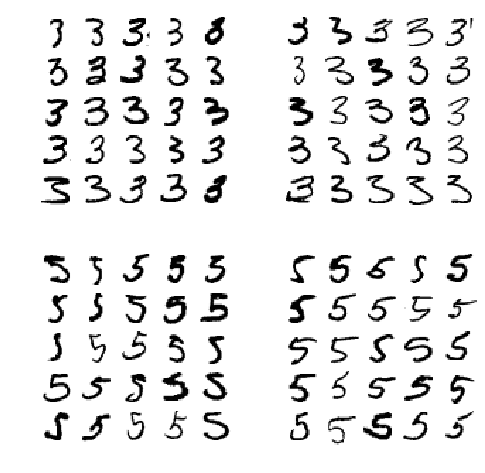

In [129]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) # top left
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) # top right
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) # bottom left
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) # bottom right
plt.show()

The model gets many of these seemingly obvious numbers wrong because it's using a simple SGDClassifier, which is a linear model. It assignsa weight per class to each pixel, and when it sees a new image it sums up the weighted pixel intensities to get a score for each class. Since 3s and 5s differ by only a few pixels, this model easily confuses them.

One way to help the confusion would be to preprocess the images to ensure they are well centered and not too rotated.

# Multilabel Classification

Until now each instance has always been assigned to just one class. But what if we want to output multiple classes for each instance, like a face-recognition classifier with several people in the same picture? We want it to attach one label per person it recognizes.

For example, if we train it to recognize Alice, Bob, and Charlie, a pic of Alice and Charlie should output [1, 0, 1]. This is called a *multilabel classification system*.

In [133]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [151]:
y_multilabel.shape

(60000, 2)

In [152]:
knn_clf.predict([some_digit])

array([[False,  True]])

This is correct because 5 is not >= 7, but is odd.

There are many ways to evaluate a multilabel classifier, and selecting the right metric depends on the project.

One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [154]:
# This calculation takes hours so it's commented out
'''
y_train_knn_pred = cross_val_predict(knn_clf, 
                                     X_train, y_multilabel, 
                                     cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')
'''

"\ny_train_knn_pred = cross_val_predict(knn_clf, \n                                     X_train, y_multilabel, \n                                     cv=3, n_jobs=-1)\nf1_score(y_multilabel, y_train_knn_pred, average='macro')\n"

Output for the above is:
0.97709078477525

This assumes that all labels are equally important, which may not be the case. Ie if you have more pics of Alice than Bob/Charlie, we may want to give more weight to the classifier's score on pics of Alice.

One simple option is to give each label a weight equal to its *support* (ie the number of instances with that target label). To do this, simply set average='weighted' in the preceding code.

# Multioutput Classification

*Multioutput-multiclass classification* (multioutput classification) is multilabel classification where each label can be multiclass (ie can have more than two possible values).

To illustrate, let's build a system that removes noise from images. Takes in a noisy digit image, and outputs a clean digit image (represented as array of px intensities like MNIST images). The classifier's output is multilabel (one label per pixel) and each label can have multiple values (px intensity ranges from 0 to 255).

We'll start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy's randint() function. The target images will be the original images:

In [156]:
noise = np.random.randint(0, 100, (len(X_train), 784)) # last part is shape of array
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's peek at an image from the test set (even though we shouldn't look at test set normally):

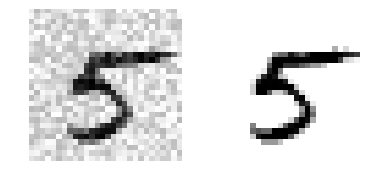

In [157]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

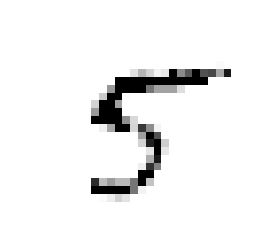

In [162]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)